# Table of Contents
 <p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import epistasis as epi
import scipy as scipy

from matplotlib import rc

import os
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})


%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
q = 0.1
genmap = pd.read_csv('../sleuth/rna_seq_info.txt', sep=' ', comment='#')
tidy  = pd.read_csv('../output/dpy_22_results.csv')

In [3]:
def log_likelihood(X, x, y, xy, xy_se):
    """Assumes a Normal Distribution and returns the log-likelihood of the events given a parameter X
    X - a number between 0 and 1
    x, y, xy - measurements
    xy_se - std of each point xy
    """
    # calculate weighted average
    model = X*x + (1-X)*y
    
    chi2 = (xy - model)**2
    sigma = xy_se
    
    #return log model
    return  -(chi2/(2*sigma**2)).sum()

def neg_log_likelihood(X, x, y, xy, xy_se):
    return -log_likelihood(X, x, y, xy, xy_se)

In [27]:
x = tidy[(tidy['phenotypic class'] == 'bx93 associated') & (tidy.strain == 'PS4087')].b.values
y = tidy[(tidy['phenotypic class'] == 'bx93 associated') & (tidy.strain == 'PS4187')].b.values
xy = tidy[(tidy['phenotypic class'] == 'bx93 associated') & (tidy.strain == 'PS4176')].b.values
se_xy = tidy[(tidy['phenotypic class'] == 'bx93 associated') & (tidy.strain == 'PS4176')].se_b.values

Warning, log-likelihood has very large absolute values. Arbitrarily subtracting Y.mean() from Y
Warning, after renormalization, the absolute likelihood values remain large. Plotting log-likelihood instead.
Estimating standard deviation. Estimation is not exact.
dominance: 0.19 +/- 0.01


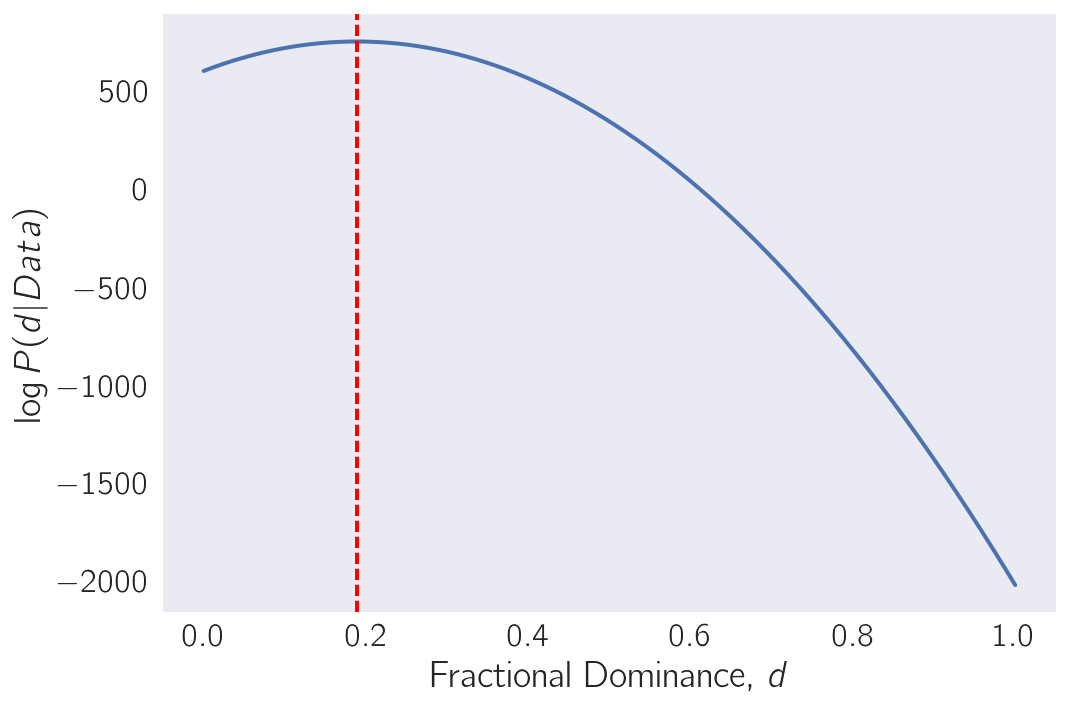

In [58]:
def dominance_distribution(x, y, xy, se_xy):
    """
    Returns the dominance distribution for a set of measurements.
    """
    X = np.linspace(0, 1, 1000)
    Y = np.array([neg_log_likelihood(xi, x, y, xy, se_xy) for xi in X])
    
    if (np.abs(Y) > 2.5*10**3).any():
        print('Warning, log-likelihood has very large absolute values. Arbitrarily subtracting Y.mean() from Y')
        Y = Y - Y.mean()
    
    fig, ax = plt.subplots()
    if (np.abs(Y) > 10**3).any():
        print('Warning, after renormalization, the absolute likelihood values remain large. Plotting log-likelihood instead.')
        plt.plot(X, -Y)
        plt.xlabel(r'Fractional Dominance, $d$')
        plt.ylabel(r'$\log{P(d | Data)}$')
        mean = X[np.where(Y == Y.min())][0]
        
        # estimate the standard deviation:
        print('Estimating standard deviation. Estimation is not exact.')
        Yprime = Y[np.where(Y < 0.8*Y.min())] - Y.min()
        expY = np.exp(-Yprime)/np.exp(-Yprime).sum()
        std = np.sqrt(((X[np.where(Y < 0.8*Y.min())] - mean)**2*expY).sum())        
    else:
        expY = np.exp(-Y)/np.exp(-Y).sum() # normalize 
        mean = (expY*X).sum()
        std = np.sqrt(((X - mean)**2*expY).sum())

        plt.plot(X, expY)
        plt.xlabel(r'Fractional Dominance, $d$')
        plt.ylabel(r'$P(d | Data)$')

    plt.axvline(mean, color='red', ls='--')
    
    return mean, std

mean, std = dominance_distribution(x, y, xy, se_xy)
print('dominance: {0:.2f} +/- {1:.2f}'.format(mean, std))

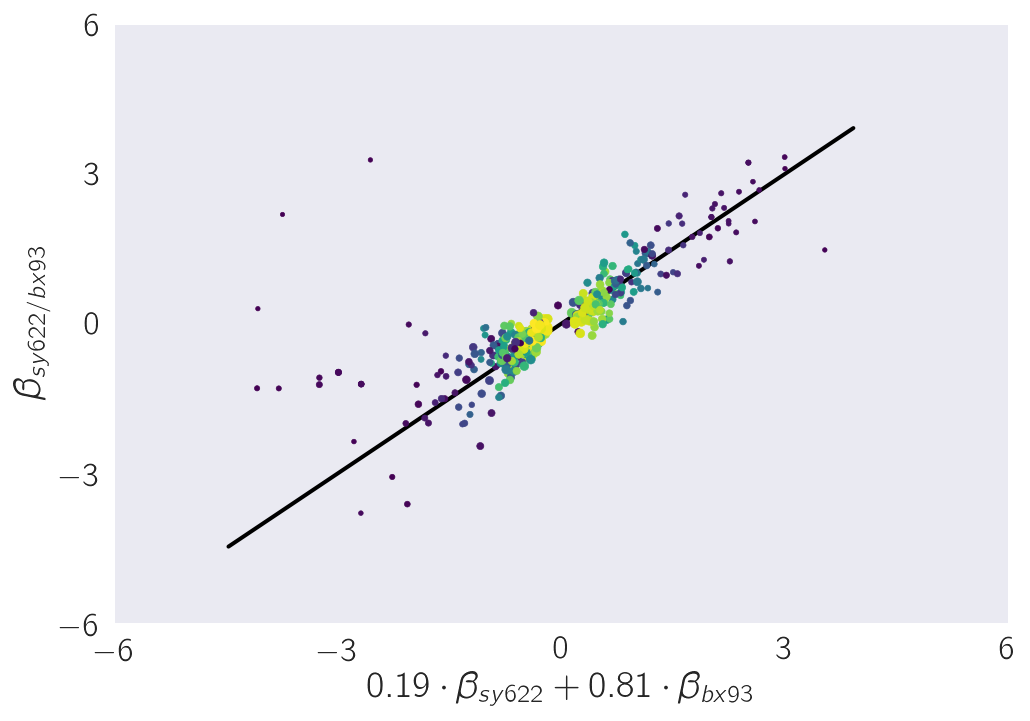

In [59]:
def density_color(x, y):
    points = np.vstack([x, y])
    z = scipy.stats.gaussian_kde(points)(points)
    return z

def dominance_plot(x, y, xy, se_xy, mixing_factor, s0=3, **kwargs):
    """Given a set of measurements and a mixing factor, make a dominance plot"""
    size = np.sqrt(se_xy)
    
    fig, ax = plt.subplots()
    ax.scatter(mixing_factor*x + (1-mixing_factor)*y, xy, s=s0/size, **kwargs)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    ax.plot(lims, lims, 'k-', alpha=1, zorder=0)

    plt.xlabel(r'${0:.2g}\cdot \beta_{{sy622}} + {1:.2g}\cdot\beta_{{bx93}}$'.format(mean, 1-mean))
    plt.ylabel(r'$\beta_{{sy622/bx93}}$'.format(mean, 1-mean))
    
    return ax

density = density_color(x, y)
ax = dominance_plot(x, y, xy, se_xy, 0.2, alpha=1, cmap='viridis', c=density, s0=5)

plt.xticks([-6, -3, 0, 3, 6])
plt.yticks([-6, -3, 0, 3, 6])

plt.savefig('../output/bx93_associated_dominance.svg', bbox_inches='tight')

In [7]:
x = tidy[(tidy['phenotypic class'] == 'sy622 associated') & (tidy.strain == 'PS4087')].b.values
y = tidy[(tidy['phenotypic class'] == 'sy622 associated') & (tidy.strain == 'PS4187')].b.values
xy = tidy[(tidy['phenotypic class'] == 'sy622 associated') & (tidy.strain == 'PS4176')].b.values
se_xy = tidy[(tidy['phenotypic class'] == 'sy622 associated') & (tidy.strain == 'PS4176')].se_b.values

Warning, Y is very large. Arbitrarily subtracting Y.mean() from Y
dominance: 0.45 +/- 0.01


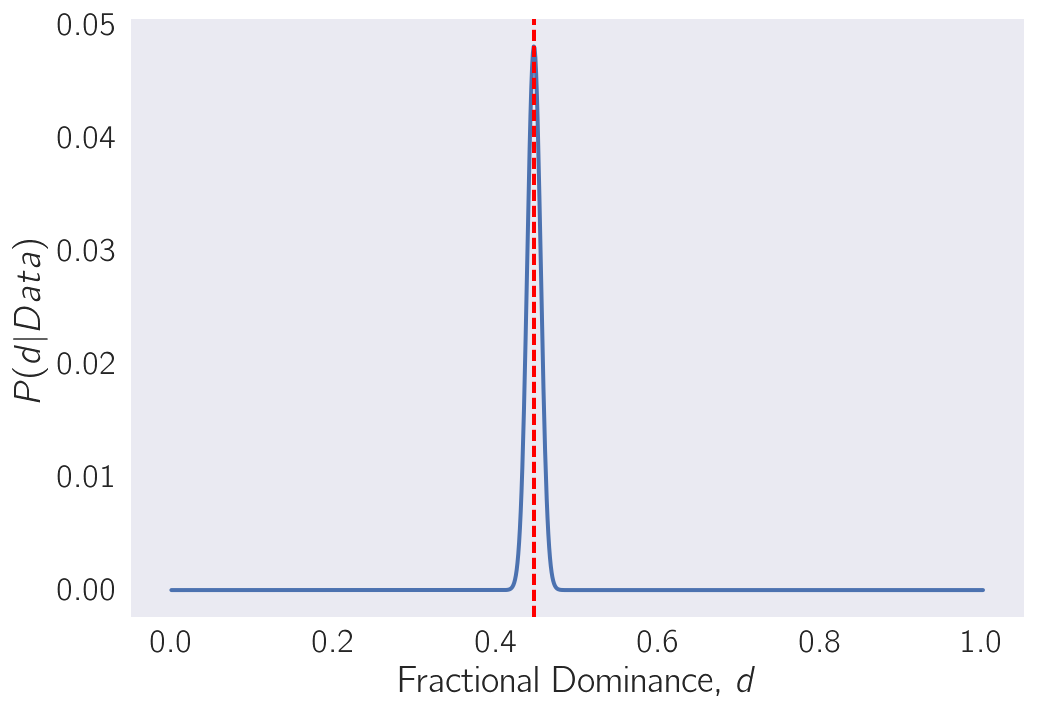

In [8]:
mean, std = dominance_distribution(x, y, xy, se_xy)
print('dominance: {0:.2f} +/- {1:.2f}'.format(mean, std))

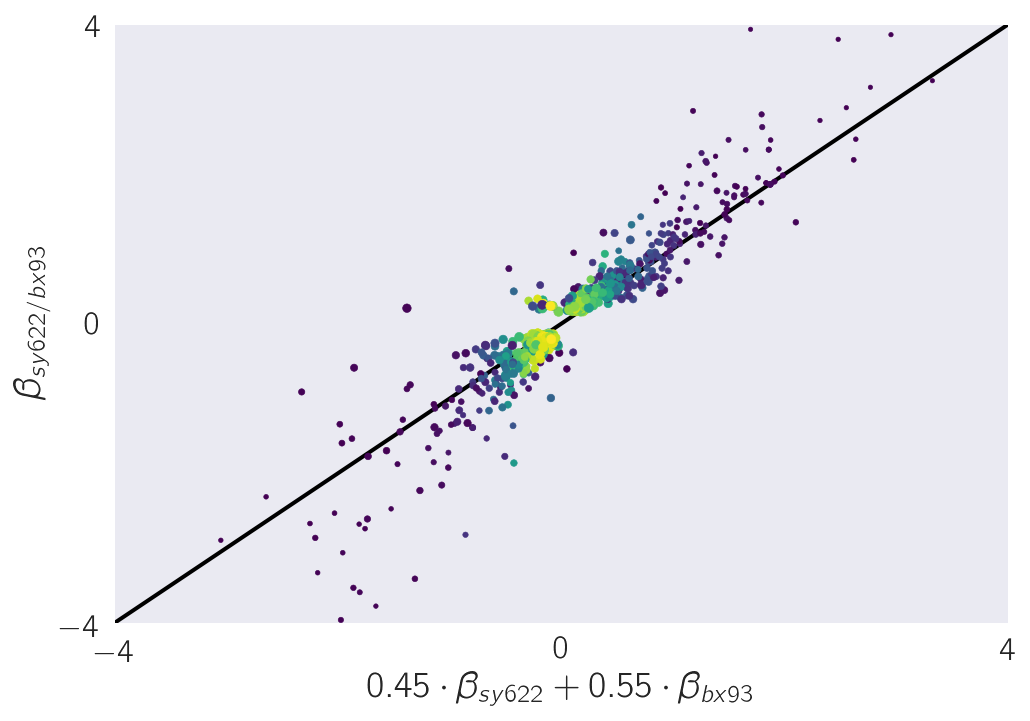

In [9]:
density = density_color(x, y)
ax = dominance_plot(x, y, xy, se_xy, mean, alpha=1, c=density, cmap='viridis', s0=5)

plt.xlim(-4, 4)
plt.ylim(-4, 4)

plt.xticks([-4, 0, 4])
plt.yticks([-4, 0, 4])

plt.savefig('../output/sy622_associated_dominance.svg', bbox_inches='tight')